In [59]:
pip install shap


Note: you may need to restart the kernel to use updated packages.


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Columns: 125 entries, SubjectID to Date
dtypes: float64(119), object(6)
memory usage: 985.5+ KB
None

Missing values:
SubjectID       0
unnamed_1    1009
T_offset1      54
Max1R13_1      53
Max1L13_1      53
             ... 
Humidity        0
Distance        2
Cosmetics      32
Time            0
Date            0
Length: 125, dtype: int64
Binning 0.001 GB of training data: 0.055 s
Fitting gradient boosted rounds:
Fit 1000 trees in 1.034 s, (11119 total leaves)
Time spent computing histograms: 0.210s
Time spent finding best splits:  0.251s
Time spent applying splits:      0.121s
Time spent predicting:           0.012s
Mean Squared Error: 0.0684
Root Mean Squared Error: 0.2615
R-squared Score: 0.5390


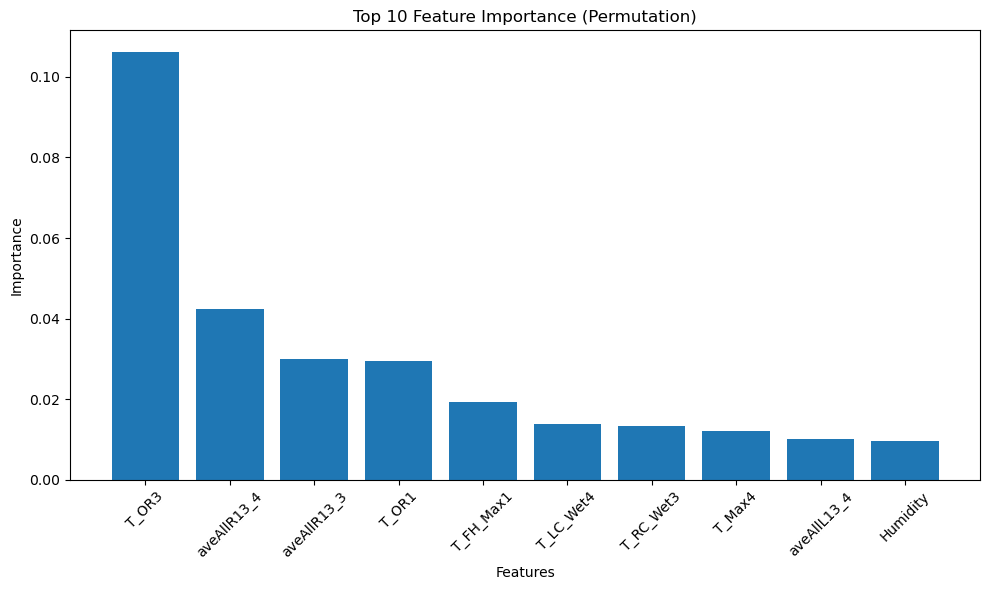


Top 10 Most Important Features:
         Feature  Importance
82         T_OR3    0.106205
88   aveAllR13_4    0.042399
60   aveAllR13_3    0.030046
26         T_OR1    0.029445
23     T_FH_Max1    0.019275
96     T_LC_Wet4    0.013913
64     T_RC_Wet3    0.013464
109       T_Max4    0.012117
89   aveAllL13_4    0.010070
117     Humidity    0.009584


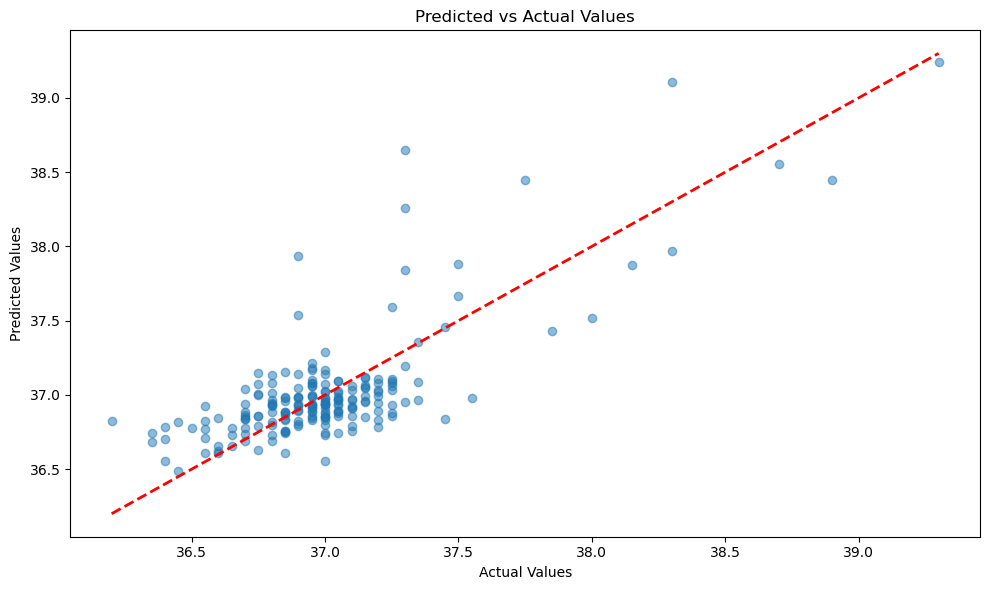

In [8]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance  # Added for feature importance
import matplotlib.pyplot as plt

# Load and fix the dataset
file_path = r"ICI_groups1and2.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"Error: File not found at {file_path}")
    print("Please verify the file path and ensure the CSV file exists in that location")
    exit()

# Set column names from row 1 and handle duplicates
df.columns = df.iloc[1]
df = df.drop([0, 1]).reset_index(drop=True)

# Handle column names
columns = []
seen = {}
for col in df.columns:
    if pd.isna(col) or col == 'nan':
        col = f"unnamed_{len(seen)}"
    if col in seen:
        seen[col] += 1
        columns.append(f"{col}_{seen[col]}")
    else:
        seen[col] = 0
        columns.append(col)
df.columns = columns

# Convert numeric columns
categorical_cols = ['SubjectID', 'Gender', 'Ethnicity', 'Cosmetics', 'Time', 'Date']
numeric_columns = [col for col in df.columns if col not in categorical_cols]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

# Display basic information
print("Dataset Info:")
print(df.info())
print("\nMissing values:")
print(df.isnull().sum())

# Data Preprocessing
target = 'aveOralF'
features = [col for col in df.columns if col not in ['aveOralF', 'aveOralM', 'SubjectID', 'Time', 'Date']]

# Handle categorical variables
categorical_features = ['Gender', 'Ethnicity', 'Cosmetics']
for col in categorical_features:
    df[col] = df[col].astype('category')

# Handle missing values
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Split features and target
X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Initialize and train the HistGradientBoosting model
model = HistGradientBoostingRegressor(
    max_iter=1000,
    learning_rate=0.1,
    max_depth=6,
    random_state=42,
    categorical_features=[X.columns.get_loc(col) for col in categorical_features],
    verbose=1
)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R-squared Score: {r2:.4f}")

# Feature Importance using permutation importance
perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': perm_importance.importances_mean
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'][:10], feature_importance_df['Importance'][:10])
plt.xticks(rotation=45)
plt.title('Top 10 Feature Importance (Permutation)')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot predicted vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values')
plt.tight_layout()
plt.show()

In [10]:
#implementing shap############################################################################################




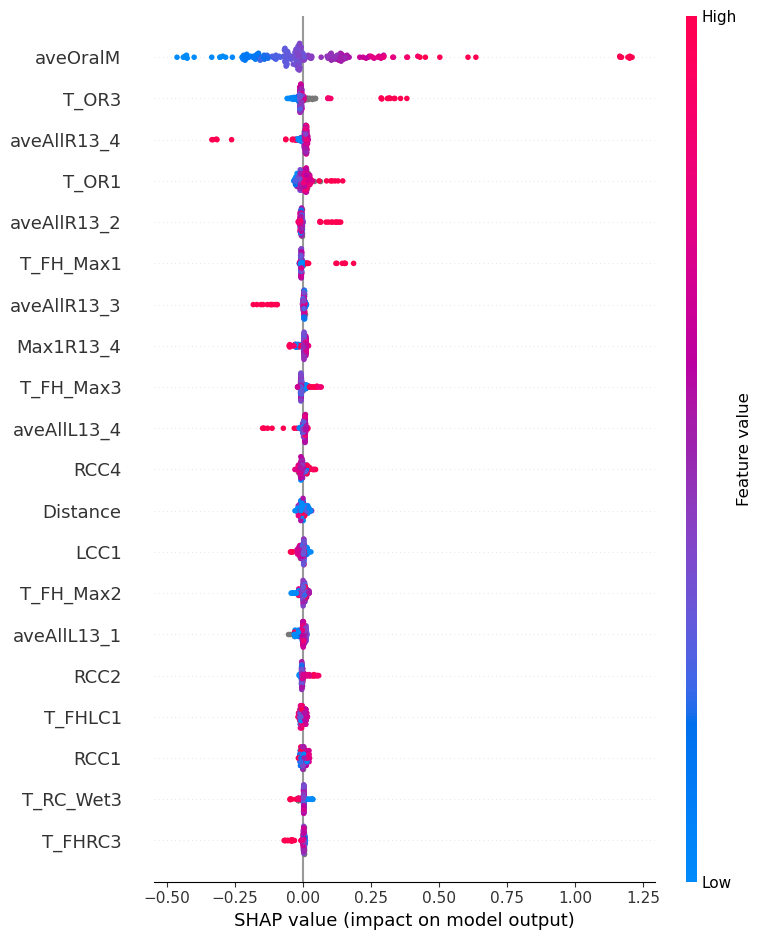

In [14]:
import shap
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("ICI_groups1and2.csv", skiprows=1)

# Rename columns based on the first row (previously treated as data)
df.columns = df.iloc[0]
df = df[1:].reset_index(drop=True)

# Convert all numerical columns to float where possible
df = df.apply(pd.to_numeric, errors='coerce')

# Drop any columns that are completely NaN after conversion
df = df.dropna(axis=1, how='all')

# Define target variable and features
target = 'aveOralF'  # Assuming this as the regression target
features = [col for col in df.columns if col != target]

# Drop rows with missing target values
df = df.dropna(subset=[target])

# Split features and target
X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a regression model
model = HistGradientBoostingRegressor(max_iter=500, learning_rate=0.1, max_depth=6, random_state=42)
model.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Generate SHAP summary plot
shap.summary_plot(shap_values, X_test)


In [18]:
#tabular shap values#######################






In [16]:
 pd.DataFrame(np.round(shap_values.values,3)).head(3)

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,0.002,-0.001,-0.003,-0.001,-0.001,0.000,-0.000,0.004,0.001,-0.001,...,0.009,-0.001,-0.003,-0.001,-0.001,0.287,0.002,-0.006,0.006,-0.009
1,-0.005,-0.004,-0.005,-0.001,0.002,-0.004,0.003,0.002,0.001,-0.001,...,0.003,-0.011,0.006,-0.001,-0.004,-0.064,-0.000,-0.003,-0.001,0.004
2,-0.003,-0.001,0.003,0.002,-0.031,-0.001,0.009,-0.000,0.000,-0.001,...,0.001,0.007,0.005,0.024,0.025,1.165,0.001,-0.009,-0.002,0.001


In [20]:
#base value#########




In [22]:
pd.DataFrame(np.round(shap_values.base_values,3)).head(3)

,0
0,36.949
1,36.949
2,36.949


In [26]:
#original training data#####$###




In [24]:
pd.DataFrame(np.round(shap_values.data,3)).head(3)

,0,1,2,3,4,5,6,7,8,9,...,103,104,105,106,107,108,109,110,111,112
0,-0.22,35.55,35.83,34.89,35.37,35.98,35.47,35.98,36.01,35.96,...,35.81,35.50,36.01,35.86,35.91,37.54,24.1,21.8,0.6,1.0
1,-0.31,36.18,35.86,35.79,35.30,36.16,36.14,36.11,36.18,36.02,...,35.65,35.63,37.40,37.29,37.40,36.89,24.0,20.5,0.6,0.0
2,0.01,36.92,37.61,36.61,37.26,36.91,36.91,36.88,36.92,37.62,...,36.92,36.59,38.29,38.25,38.29,38.69,24.1,41.3,0.6,0.0


In [50]:
#categorising the dataset############






In [30]:
import shap

In [32]:
 import pandas as pd

In [34]:
 import sklearn

In [36]:
 from sklearn import tree, metrics, model_selection, preprocessing

In [38]:
 from IPython.display import Image, display

In [40]:
 from sklearn.metrics import confusion_matrix, classification_report

In [42]:
model = tree. DecisionTreeRegressor() # plain tree model

In [44]:
columns = []
seen = {}
for col in df.columns:
    if pd.isna(col) or col == 'nan':
        col = f"unnamed_{len(seen)}"
    if col in seen:
        seen[col] += 1
        columns.append(f"{col}_{seen[col]}")
    else:
        seen[col] = 0
        columns.append(col)
df.columns = columns


In [46]:
categorical_cols = ['SubjectID', 'Gender', 'Ethnicity', 'Cosmetics', 'Time', 'Date']
numeric_columns = [col for col in df.columns if col not in categorical_cols]
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

In [48]:
print("Dataset Info:")
print(df.info())
print("\nFirst few rows:")
print(df.head())
print("\nMissing values:")
print(df.isnull().sum())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Columns: 114 entries, T_offset1 to Cosmetics
dtypes: float64(114)
memory usage: 898.8 KB
None

First few rows:
   T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1  aveAllL13_1  T_RC1  \
0      -0.27      34.94      35.48        34.05        34.74  34.92   
1      -0.21      33.56      34.93        33.23        34.14  34.80   
2      -0.28      35.91      35.60        35.46        34.71  35.83   
3      -0.32      35.25      35.46        33.78        33.88  35.24   
4      -0.52      35.57      35.78        34.38        35.27  35.60   

   T_RC_Dry1  T_RC_Wet1  T_RC_Max1  T_LC1  ...  T_FHC_Max4  T_Max4  T_OR4  \
0      34.92      34.71      34.94  35.45  ...       33.73   36.39  36.38   
1      33.97      34.80      34.89  34.88  ...       34.17   36.30  36.28   
2      35.83      35.50      35.91  35.58  ...       35.16   36.63  36.59   
3      35.20      35.22      35.25  35.60  ...       34.34   35.88

In [52]:
#partial dependency plot####







In [69]:
# Set proper column names using the second row and drop unnecessary rows
df.columns = df.iloc[1]
df = df[2:].reset_index(drop=True)

# Drop unnamed columns that are fully NaN
df = df.dropna(axis=1, how='all')

# Display the cleaned dataframe info and first few rows
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Columns: 120 entries, SubjectID to Date
dtypes: object(120)
memory usage: 946.1+ KB


(None,
 1 SubjectID T_offset1 Max1R13_1 Max1L13_1 aveAllR13_1 aveAllL13_1  T_RC1  \
 0  161117-1     -0.27     34.94     35.48       34.05       34.74  34.92   
 1  161117-2     -0.21     33.56     34.93       33.23       34.14  34.80   
 2  161117-3     -0.28     35.91     35.60       35.46       34.71  35.83   
 3  161117-4     -0.32     35.25     35.46       33.78       33.88  35.24   
 4  161117-5     -0.52     35.57     35.78       34.38       35.27  35.60   
 
 1 T_RC_Dry1 T_RC_Wet1 T_RC_Max1  ... aveOralM  Gender    Age  \
 0     34.92     34.71     34.94  ...    36.59    Male  41-50   
 1     33.97     34.80     34.89  ...    37.19  Female  31-40   
 2     35.83     35.50     35.91  ...    37.34  Female  21-30   
 3     35.20     35.22     35.25  ...    37.09  Female  21-30   
 4     35.54     35.60     35.66  ...    37.04    Male  18-20   
 
 1                  Ethnicity T_atm Humidity Distance Cosmetics      Time  \
 0                      White    24       28      0.8       

In [89]:
shap.partial_dependence_plot

<function shap.plots._partial_dependence.partial_dependence(ind, model, data, xmin='percentile(0)', xmax='percentile(100)', npoints=None, feature_names=None, hist=True, model_expected_value=False, feature_expected_value=False, shap_values=None, ylabel=None, ice=True, ace_opacity=1, pd_opacity=1, pd_linewidth=2, ace_linewidth='auto', ax=None, show=True)>

In [101]:
df.columns.tolist()

['SubjectID',
 'T_offset1',
 'Max1R13_1',
 'Max1L13_1',
 'aveAllR13_1',
 'aveAllL13_1',
 'T_RC1',
 'T_RC_Dry1',
 'T_RC_Wet1',
 'T_RC_Max1',
 'T_LC1',
 'T_LC_Dry1',
 'T_LC_Wet1',
 'T_LC_Max1',
 'RCC1',
 'LCC1',
 'canthiMax1',
 'canthi4Max1',
 'T_FHCC1',
 'T_FHRC1',
 'T_FHLC1',
 'T_FHBC1',
 'T_FHTC1',
 'T_FH_Max1',
 'T_FHC_Max1',
 'T_Max1',
 'T_OR1',
 'T_OR_Max1',
 'T_offset2',
 'Max1R13_2',
 'Max1L13_2',
 'aveAllR13_2',
 'aveAllL13_2',
 'T_RC2',
 'T_RC_Dry2',
 'T_RC_Wet2',
 'T_RC_Max2',
 'T_LC2',
 'T_LC_Dry2',
 'T_LC_Wet2',
 'T_LC_Max2',
 'RCC2',
 'LCC2',
 'canthiMax2',
 'canthi4Max2',
 'T_FHCC2',
 'T_FHRC2',
 'T_FHLC2',
 'T_FHBC2',
 'T_FHTC2',
 'T_FH_Max2',
 'T_FHC_Max2',
 'T_Max2',
 'T_OR2',
 'T_OR_Max2',
 'T_offset3',
 'Max1R13_3',
 'Max1L13_3',
 'aveAllR13_3',
 'aveAllL13_3',
 'T_RC3',
 'T_RC_Dry3',
 'T_RC_Wet3',
 'T_RC_Max3',
 'T_LC3',
 'T_LC_Dry3',
 'T_LC_Wet3',
 'T_LC_Max3',
 'RCC3',
 'LCC3',
 'canthiMax3',
 'canthi4Max3',
 'T_FHCC3',
 'T_FHRC3',
 'T_FHLC3',
 'T_FHBC3',
 'T_FHTC3

In [107]:
X = X.dropna()
y = y.loc[X.index]  # Keep only corresponding `y` values


In [111]:
print(y.dtype)
print(y.head())  # Check the first few values


object
0    35.73
1    35.21
2    35.97
3    35.10
4    35.59
Name: T_OR3, dtype: object


In [113]:
y = pd.to_numeric(y, errors='coerce')  # Convert non-numeric to NaN
y = y.fillna(y.mean())  # Fill NaNs after conversion


In [115]:
print(y.dtype)  # Should be float or int
print(y.isna().sum())  # Check if NaNs are handled


float64
0


In [117]:
# Handle missing values
X = X.fillna(X.mean())  # Fill NaNs in features
y = y.fillna(y.mean())  # Fill NaNs in target


In [123]:
print(X.isna().sum())
print(y.isna().sum())


SubjectID_161117-2    0
SubjectID_161117-3    0
SubjectID_161117-4    0
SubjectID_161117-5    0
SubjectID_161117-6    0
                     ..
Date_18-04-24         0
Date_18-04-25         0
Date_18-05-02         0
Date_18-05-07         0
Date_18-05-14         0
Length: 31764, dtype: int64
113


In [141]:
y = pd.to_numeric(y, errors='coerce')  # Converts invalid values to NaN


In [153]:
import pandas as pd

# Load the dataset
file_path = "ICI_groups1and2.csv"
df = pd.read_csv(file_path)

# Display basic information and the first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Columns: 125 entries, Unnamed: 0 to Unnamed: 124
dtypes: float64(5), object(120)
memory usage: 987.4+ KB


(None,
   Unnamed: 0  Unnamed: 1   Round 1: Unnamed: 3 Unnamed: 4   Unnamed: 5  \
 0        NaN         NaN        NaN    T_CRmax    T_CLmax        T̅_CR   
 1  SubjectID         NaN  T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1   
 2   161117-1         NaN      -0.27      34.94      35.48        34.05   
 3   161117-2         NaN      -0.21      33.56      34.93        33.23   
 4   161117-3         NaN      -0.28      35.91      35.60        35.46   
 
     Unnamed: 6 Unnamed: 7 Unnamed: 8 Unnamed: 9  ... Unnamed: 115  \
 0        T̅_CL        NaN        NaN        NaN  ...          NaN   
 1  aveAllL13_1      T_RC1  T_RC_Dry1  T_RC_Wet1  ...     aveOralM   
 2        34.74      34.92      34.92      34.71  ...        36.59   
 3        34.14      34.80      33.97      34.80  ...        37.19   
 4        34.71      35.83      35.83      35.50  ...        37.34   
 
   Unnamed: 116 Unnamed: 117               Unnamed: 118 Unnamed: 119  \
 0          NaN          NaN                   

In [155]:
X = X.apply(pd.to_numeric, errors='coerce')  # Convert everything to numeric, replacing errors with NaN


In [157]:
X = X.dropna(axis=1, thresh=int(0.7 * len(X)))  # Keep columns with at least 70% valid data


In [161]:
import pandas as pd

# Assuming 'y' is your pandas Series
y = pd.to_numeric(y, errors='coerce')  # Convert to numeric, invalid values become NaN
y = y.fillna(y.mean())  # Fill NaN values with the mean

# Now you can work with the updated 'y'


In [169]:
y = y.fillna(y.mean())  # Replace NaNs with the mean


In [173]:
# Set proper column names using the second row and drop unnecessary rows
df.columns = df.iloc[1]
df = df[2:].reset_index(drop=True)

# Drop unnamed columns that are fully NaN
df = df.dropna(axis=1, how='all')

# Display the cleaned dataframe info and first few rows
df.info(), df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Columns: 120 entries, SubjectID to Date
dtypes: object(120)
memory usage: 946.1+ KB


(None,
 1 SubjectID T_offset1 Max1R13_1 Max1L13_1 aveAllR13_1 aveAllL13_1  T_RC1  \
 0  161117-1     -0.27     34.94     35.48       34.05       34.74  34.92   
 1  161117-2     -0.21     33.56     34.93       33.23       34.14  34.80   
 2  161117-3     -0.28     35.91     35.60       35.46       34.71  35.83   
 3  161117-4     -0.32     35.25     35.46       33.78       33.88  35.24   
 4  161117-5     -0.52     35.57     35.78       34.38       35.27  35.60   
 
 1 T_RC_Dry1 T_RC_Wet1 T_RC_Max1  ... aveOralM  Gender    Age  \
 0     34.92     34.71     34.94  ...    36.59    Male  41-50   
 1     33.97     34.80     34.89  ...    37.19  Female  31-40   
 2     35.83     35.50     35.91  ...    37.34  Female  21-30   
 3     35.20     35.22     35.25  ...    37.09  Female  21-30   
 4     35.54     35.60     35.66  ...    37.04    Male  18-20   
 
 1                  Ethnicity T_atm Humidity Distance Cosmetics      Time  \
 0                      White    24       28      0.8       

In [175]:
# Convert numerical columns to proper data types
for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except ValueError:
        pass  # Keep non-numeric columns as they are

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

# Display identified categorical columns
categorical_cols

['SubjectID', 'Gender', 'Age', 'Ethnicity', 'Time', 'Date']

In [177]:
# Drop SubjectID as it's an identifier
df = df.drop(columns=['SubjectID'])

# Convert Age to numeric
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# Encode categorical columns (Gender, Ethnicity) using one-hot encoding
df = pd.get_dummies(df, columns=['Gender', 'Ethnicity'], drop_first=True)

# Drop Time and Date columns as they may not be relevant for modeling
df = df.drop(columns=['Time', 'Date'], errors='ignore')

# Display dataset info after processing
df.info(), df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1009 entries, 0 to 1008
Columns: 121 entries, T_offset1 to Ethnicity_White
dtypes: bool(6), float64(115)
memory usage: 912.6 KB


(None,
    T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1  aveAllL13_1  T_RC1  \
 0      -0.27      34.94      35.48        34.05        34.74  34.92   
 1      -0.21      33.56      34.93        33.23        34.14  34.80   
 2      -0.28      35.91      35.60        35.46        34.71  35.83   
 3      -0.32      35.25      35.46        33.78        33.88  35.24   
 4      -0.52      35.57      35.78        34.38        35.27  35.60   
 
    T_RC_Dry1  T_RC_Wet1  T_RC_Max1  T_LC1  ...  T_atm  Humidity  Distance  \
 0      34.92      34.71      34.94  35.45  ...   24.0      28.0       0.8   
 1      33.97      34.80      34.89  34.88  ...   24.0      26.0       0.8   
 2      35.83      35.50      35.91  35.58  ...   24.0      26.0       0.8   
 3      35.20      35.22      35.25  35.60  ...   24.0      27.0       0.8   
 4      35.54      35.60      35.66  35.72  ...   24.0      27.0       0.8   
 
    Cosmetics  Gender_Male  Ethnicity_Asian  \
 0        NaN         True            Fals

In [179]:
target = 'T_RC1'

In [181]:
X = df.drop(columns=[target])

In [183]:
y = df[target]

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [187]:
model = RandomForestRegressor(n_estimators=100, random_state=42)

In [189]:
missing_values = df.isnull().mean() * 100

In [191]:
missing_values[missing_values > 0].sort_values(ascending=False)

Age            100.000000
T_RC_Dry4       13.082260
T_FHLC4         13.082260
T_LC_Max4       13.082260
T_LC14          13.082260
                  ...    
Max1L13_1        5.252725
Max1R13_1        5.252725
aveAllL13_1      5.252725
Cosmetics        3.171457
Distance         0.198216
Length: 111, dtype: float64

In [207]:
import pandas as pd

# Load the cleaned CSV
data = pd.read_csv("ICI_groups1and2.csv")
print(data.columns)  # Verify column names

Index(['Unnamed: 0', 'Unnamed: 1', 'Round 1:', 'Unnamed: 3', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       ...
       'Unnamed: 115', 'Unnamed: 116', 'Unnamed: 117', 'Unnamed: 118',
       'Unnamed: 119', 'Unnamed: 120', 'Unnamed: 121', 'Unnamed: 122',
       'Unnamed: 123', 'Unnamed: 124'],
      dtype='object', length=125)


In [211]:
import pandas as pd

# Define column names based on the dataset structure
column_names = [
    'SubjectID', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1',
    # ... (add all columns up to Round 4 as needed) ...
    'T_CRmax4', 'T_CLmax4', 'T̅_CR4', 'T̅_CL4', 'T_CEmax4', 'T_FC4', 'T_FR4', 'T_FL4',
    'T_FB4', 'T_FT4', 'T_FEmax4', 'T_FCmax4', 'T_max4', 'T_Mmax4',
    'aveOralF', 'aveOralM', 'Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity',
    'Distance', 'Cosmetics', 'Time', 'Date'
]

# Load the data with custom column names
data = pd.read_csv("ICI_groups1and2.csv", names=column_names, skiprows=1)  # skiprows=1 to skip the original header
print(data.columns)  # Verify
print(data.head())   # Check the first few rows

Index(['SubjectID', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1',
       'aveAllL13_1', 'T_CRmax4', 'T_CLmax4', 'T̅_CR4', 'T̅_CL4', 'T_CEmax4',
       'T_FC4', 'T_FR4', 'T_FL4', 'T_FB4', 'T_FT4', 'T_FEmax4', 'T_FCmax4',
       'T_max4', 'T_Mmax4', 'aveOralF', 'aveOralM', 'Gender', 'Age',
       'Ethnicity', 'T_atm', 'Humidity', 'Distance', 'Cosmetics', 'Time',
       'Date'],
      dtype='object')
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [213]:
data = pd.read_csv("ICI_groups1and2.csv", sep=',', skiprows=2)  # Adjust skiprows based on where the actual data starts
print(data.columns)

Index(['SubjectID', 'Unnamed: 1', 'T_offset1', 'Max1R13_1', 'Max1L13_1',
       'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1',
       ...
       'aveOralM', 'Gender', 'Age', 'Ethnicity', 'T_atm', 'Humidity',
       'Distance', 'Cosmetics', 'Time', 'Date'],
      dtype='object', length=125)


In [ ]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("ICI_groups1and2.csv")

# Set proper column names using the second row and drop unnecessary rows
df.columns = df.iloc[1]
df = df[2:].reset_index(drop=True)

# Drop unnamed columns that are fully NaN
df = df.dropna(axis=1, how='all')

# Verify available columns
print("Columns in dataset:", df.columns.tolist())

# Define target and features (Ensure the target column exists)
target = "T_OR3"  # Change if another target is more relevant
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in dataset!")

X = df.drop(columns=[target])
y = df[target]

# Convert categorical variables if any
X = pd.get_dummies(X, drop_first=True)

# Train a model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Explain model predictions using SHAP
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)

# Select a feature for Partial Dependence Plot
feature = "T_offset1"  # Ensure this column exists in dataset
if feature not in X.columns:
    raise KeyError(f"Feature column '{feature}' not found in dataset!")

# Generate the SHAP Partial Dependence Plot
shap.partial_dependence_plot(
    ind=feature,  # Feature of interest
    model=model.predict,
    X=X_test,
    feature_expected_value=True,
    ice=False
)

plt.show()

In [10]:
numeric_cols = X.select_dtypes(include=['object']).columns.difference(['Gender', 'Age', 'Ethnicity', 'Date', 'Time'])
X[numeric_cols] = X[numeric_cols].apply(pd.to_numeric, errors='coerce')
y = pd.to_numeric(y, errors='coerce')

In [12]:
X = X.fillna(X.mean())  # Simple imputation with mean
y = y.dropna()
X = X.loc[y.index]  # Align X with y after dropping NaNs

In [32]:
df = pd.read_csv("ICI_groups1and2.csv", header=1)

In [44]:
import pandas as pd
import io

# Your dataset snippet (partial, replace with full dataset)
dataset_text = """\
﻿,,Round 1:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 2:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 3:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 4:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Other parameters: ,,,,,,,,,,
,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,,,,,,,,,,
SubjectID,,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,,T_offset2,Max1R13_2,Max1L13_2,aveAllR13_2,aveAllL13_2,T_RC2,T_RC_Dry2,T_RC_Wet2,T_RC_Max2,T_LC2,T_LC_Dry2,T_LC_Wet2,T_LC_Max2,RCC2,LCC2,canthiMax2,canthi4Max2,T_FHCC2,T_FHRC2,T_FHLC2,T_FHBC2,T_FHTC2,T_FH_Max2,T_FHC_Max2,T_Max2,T_OR2,T_OR_Max2,,T_offset3,Max1R13_3,Max1L13_3,aveAllR13_3,aveAllL13_3,T_RC3,T_RC_Dry3,T_RC_Wet3,T_RC_Max3,T_LC3,T_LC_Dry3,T_LC_Wet3,T_LC_Max3,RCC3,LCC3,canthiMax3,canthi4Max3,T_FHCC3,T_FHRC3,T_FHLC3,T_FHBC3,T_FHTC3,T_FH_Max3,T_FHC_Max3,T_Max3,T_OR3,T_OR_Max3,,T_offset4,Max1R13_4,Max1L13_4,aveAllR13_4,aveAllL13_4,T_RC4,T_RC_Dry4,T_RC_Wet4,T_RC_Max4,T_LC14,T_LC_Dry4,T_LC_Wet4,T_LC_Max4,RCC4,LCC4,canthiMax4,canthi4Max4,T_FHCC4,T_FHRC4,T_FHLC4,T_FHBC4,T_FHTC4,T_FH_Max4,T_FHC_Max4,T_Max4,T_OR4,T_OR_Max4,,aveOralF,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance,Cosmetics,Time,Date
161117-1,,-0.27,34.94,35.48,34.05,34.74,34.92,34.92,34.71,34.94,35.45,35.45,34.17,35.49,34.75,33.90,35.48,35.45,33.06,32.86,32.81,32.97,32.23,34.42,33.53,35.49,35.39,35.42,,-0.49,34.91,35.34,34.10,34.79,34.90,34.90,34.65,34.91,35.33,35.33,34.22,35.34,34.77,34.17,35.34,35.33,33.17,32.98,32.88,33.16,32.44,34.30,33.59,35.74,35.73,35.74,,-0.41,35.05,35.42,34.50,34.79,35.03,35.03,34.35,35.05,35.40,35.40,34.24,35.42,34.34,34.11,35.42,35.40,33.29,33.17,32.96,33.13,32.53,34.46,33.63,35.84,35.73,35.84,,-0.58,34.96,35.51,34.16,34.60,34.94,34.94,34.80,34.96,35.41,35.41,34.04,35.51,34.85,33.74,35.51,35.41,33.31,33.18,32.97,33.22,32.65,34.10,33.73,36.39,36.38,36.39,,36.85,36.59,Male,41-50,White,24,28,0.8,,12:43:46,16-11-17
161117-2,,-0.21,33.56,34.93,33.23,34.14,34.80,33.97,34.80,34.89,34.88,34.88,33.86,34.93,33.16,33.62,34.96,34.94,33.52,33.01,32.85,33.56,33.34,34.38,33.90,34.96,34.81,34.89,,-0.56,33.79,34.57,32.73,33.95,34.54,34.09,34.54,34.56,34.54,34.54,33.72,34.57,33.45,33.31,34.57,34.57,33.95,33.61,33.30,33.99,33.75,34.60,34.26,35.45,35.19,35.24,,-0.49,33.39,33.91,33.03,33.12,34.26,34.20,34.26,34.30,34.48,34.48,34.03,34.53,32.75,32.84,34.98,34.86,33.71,33.43,33.60,33.95,33.52,34.63,34.25,35.32,35.21,35.22,,-0.39,34.31,34.32,33.03,33.92,34.73,34.43,34.73,34.79,34.46,34.33,34.46,34.54,34.15,34.12,34.79,34.73,33.65,33.86,33.44,33.67,33.52,34.36,34.17,36.30,36.28,36.30,,37.00,37.19,Female,31-40,Black or African-American,24,26,0.8,,15:22:48,16-11-17
"""

# Load the data
df = pd.read_csv(io.StringIO(dataset_text), header=1)
df = df.dropna(axis=1, how='all')
df = df.reset_index(drop=True)

# Print column names and first few rows to debug
print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())
print("First few rows:\n", df.head())

# Check if T_OR3 exists
target = "T_OR"
if target not in df.columns:
    print(f"\nError: '{target}' not found in columns!")
    print("Available columns containing 'T_OR':", [col for col in df.columns if 'T_OR' in col])
else:
    print(f"\n'{target}' found in columns!")

Shape of df: (3, 120)
Columns: ['Unnamed: 0', 'Unnamed: 2', 'T_CRmax', 'T_CLmax', 'T̅_CR', 'T̅_CL', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9', 'Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 'Unnamed: 15', 'Unnamed: 16', 'T_CEmax', 'Unnamed: 18', 'T_FC', 'T_FR', 'T_FL', 'T_FB', 'T_FT', 'T_FEmax', 'T_FCmax', 'T_max', 'Unnamed: 27', 'T_Mmax', 'Unnamed: 30', 'T_CRmax.1', 'T_CLmax.1', 'T̅_CR.1', 'T̅_CL.1', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38', 'Unnamed: 39', 'Unnamed: 40', 'Unnamed: 41', 'Unnamed: 42', 'Unnamed: 43', 'Unnamed: 44', 'T_CEmax.1', 'Unnamed: 46', 'T_FC.1', 'T_FR.1', 'T_FL.1', 'T_FB.1', 'T_FT.1', 'T_FEmax.1', 'T_FCmax.1', 'T_max.1', 'Unnamed: 55', 'T_Mmax.1', 'Unnamed: 58', 'T_CRmax.2', 'T_CLmax.2', 'T̅_CR.2', 'T̅_CL.2', 'Unnamed: 63', 'Unnamed: 64', 'Unnamed: 65', 'Unnamed: 66', 'Unnamed: 67', 'Unnamed: 68', 'Unnamed: 69', 'Unnamed: 70', 'Unnamed: 71', 'Unnamed: 72', 'T_CEmax.2', 'Unnamed: 74', 'T_FC.2', 'T_FR.2', 'T_FL.2', 'T_FB

In [38]:
df = pd.read_csv(io.StringIO(dataset_text), header=2)

In [48]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import io

# Your dataset snippet (replace with full dataset)
dataset_text = """\
﻿,,Round 1:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 2:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 3:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 4:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Other parameters: ,,,,,,,,,,
,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,,,,,,,,,,
SubjectID,,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,,T_offset2,Max1R13_2,Max1L13_2,aveAllR13_2,aveAllL13_2,T_RC2,T_RC_Dry2,T_RC_Wet2,T_RC_Max2,T_LC2,T_LC_Dry2,T_LC_Wet2,T_LC_Max2,RCC2,LCC2,canthiMax2,canthi4Max2,T_FHCC2,T_FHRC2,T_FHLC2,T_FHBC2,T_FHTC2,T_FH_Max2,T_FHC_Max2,T_Max2,T_OR2,T_OR_Max2,,T_offset3,Max1R13_3,Max1L13_3,aveAllR13_3,aveAllL13_3,T_RC3,T_RC_Dry3,T_RC_Wet3,T_RC_Max3,T_LC3,T_LC_Dry3,T_LC_Wet3,T_LC_Max3,RCC3,LCC3,canthiMax3,canthi4Max3,T_FHCC3,T_FHRC3,T_FHLC3,T_FHBC3,T_FHTC3,T_FH_Max3,T_FHC_Max3,T_Max3,T_OR3,T_OR_Max3,,T_offset4,Max1R13_4,Max1L13_4,aveAllR13_4,aveAllL13_4,T_RC4,T_RC_Dry4,T_RC_Wet4,T_RC_Max4,T_LC14,T_LC_Dry4,T_LC_Wet4,T_LC_Max4,RCC4,LCC4,canthiMax4,canthi4Max4,T_FHCC4,T_FHRC4,T_FHLC4,T_FHBC4,T_FHTC4,T_FH_Max4,T_FHC_Max4,T_Max4,T_OR4,T_OR_Max4,,aveOralF,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance,Cosmetics,Time,Date
161117-1,,-0.27,34.94,35.48,34.05,34.74,34.92,34.92,34.71,34.94,35.45,35.45,34.17,35.49,34.75,33.90,35.48,35.45,33.06,32.86,32.81,32.97,32.23,34.42,33.53,35.49,35.39,35.42,,-0.49,34.91,35.34,34.10,34.79,34.90,34.90,34.65,34.91,35.33,35.33,34.22,35.34,34.77,34.17,35.34,35.33,33.17,32.98,32.88,33.16,32.44,34.30,33.59,35.74,35.73,35.74,,-0.41,35.05,35.42,34.50,34.79,35.03,35.03,34.35,35.05,35.40,35.40,34.24,35.42,34.34,34.11,35.42,35.40,33.29,33.17,32.96,33.13,32.53,34.46,33.63,35.84,35.73,35.84,,-0.58,34.96,35.51,34.16,34.60,34.94,34.94,34.80,34.96,35.41,35.41,34.04,35.51,34.85,33.74,35.51,35.41,33.31,33.18,32.97,33.22,32.65,34.10,33.73,36.39,36.38,36.39,,36.85,36.59,Male,41-50,White,24,28,0.8,,12:43:46,16-11-17
161117-2,,-0.21,33.56,34.93,33.23,34.14,34.80,33.97,34.80,34.89,34.88,34.88,33.86,34.93,33.16,33.62,34.96,34.94,33.52,33.01,32.85,33.56,33.34,34.38,33.90,34.96,34.81,34.89,,-0.56,33.79,34.57,32.73,33.95,34.54,34.09,34.54,34.56,34.54,34.54,33.72,34.57,33.45,33.31,34.57,34.57,33.95,33.61,33.30,33.99,33.75,34.60,34.26,35.45,35.19,35.24,,-0.49,33.39,33.91,33.03,33.12,34.26,34.20,34.26,34.30,34.48,34.48,34.03,34.53,32.75,32.84,34.98,34.86,33.71,33.43,33.60,33.95,33.52,34.63,34.25,35.32,35.21,35.22,,-0.39,34.31,34.32,33.03,33.92,34.73,34.43,34.73,34.79,34.46,34.33,34.46,34.54,34.15,34.12,34.79,34.73,33.65,33.86,33.44,33.67,33.52,34.36,34.17,36.30,36.28,36.30,,37.00,37.19,Female,31-40,Black or African-American,24,26,0.8,,15:22:48,16-11-17
"""

# Load the data with correct header
df = pd.read_csv(io.StringIO(dataset_text), header=2, encoding='utf-8')
df = df.dropna(axis=1, how='all')
df = df.reset_index(drop=True)

# Debug: Check columns and data
print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())
print("First few rows:\n", df.head())

# Define target
target = "T_OR3"
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in dataset! Available 'T_OR' columns: {[col for col in df.columns if 'T_OR' in col]}")

# Select features
exclude_cols = [target, 'SubjectID', 'Gender', 'Age', 'Ethnicity', 'Date', 'Time', 'Cosmetics']
X = df.drop(columns=exclude_cols)
y = pd.to_numeric(df[target], errors='coerce')

# Convert features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle categorical variables
categorical_cols = ['Gender', 'Age', 'Ethnicity']
X_cat = pd.get_dummies(df[categorical_cols], drop_first=True)
X = pd.concat([X, X_cat], axis=1)

# Handle missing values
X = X.fillna(X.mean())
y = y.dropna()
X = X.loc[y.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
print("\nModel Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# SHAP Plots
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.title("SHAP Values Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("T_offset1", shap_values, X_test, interaction_index=None)
plt.title("SHAP Dependence Plot for T_offset1")
plt.tight_layout()
plt.show()

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
plt.title("SHAP Force Plot for First Test Sample")
plt.tight_layout()
plt.show()

Shape of df: (2, 119)
Columns: ['SubjectID', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'T_offset2', 'Max1R13_2', 'Max1L13_2', 'aveAllR13_2', 'aveAllL13_2', 'T_RC2', 'T_RC_Dry2', 'T_RC_Wet2', 'T_RC_Max2', 'T_LC2', 'T_LC_Dry2', 'T_LC_Wet2', 'T_LC_Max2', 'RCC2', 'LCC2', 'canthiMax2', 'canthi4Max2', 'T_FHCC2', 'T_FHRC2', 'T_FHLC2', 'T_FHBC2', 'T_FHTC2', 'T_FH_Max2', 'T_FHC_Max2', 'T_Max2', 'T_OR2', 'T_OR_Max2', 'T_offset3', 'Max1R13_3', 'Max1L13_3', 'aveAllR13_3', 'aveAllL13_3', 'T_RC3', 'T_RC_Dry3', 'T_RC_Wet3', 'T_RC_Max3', 'T_LC3', 'T_LC_Dry3', 'T_LC_Wet3', 'T_LC_Max3', 'RCC3', 'LCC3', 'canthiMax3', 'canthi4Max3', 'T_FHCC3', 'T_FHRC3', 'T_FHLC3', 'T_FHBC3', 'T_FHTC3', 'T_FH_Max3', 'T_FHC_Max3', 'T_Max3', 'T_OR

KeyError: "['Cosmetics'] not found in axis"

In [52]:
existing_cols = [col for col in exclude_cols if col in df.columns]
X = df.drop(columns=existing_cols)

In [54]:
available_cat_cols = [col for col in categorical_cols if col in df.columns]
X_cat = pd.get_dummies(df[available_cat_cols], drop_first=True)

Shape of df: (2, 119)
Columns: ['SubjectID', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'T_offset2', 'Max1R13_2', 'Max1L13_2', 'aveAllR13_2', 'aveAllL13_2', 'T_RC2', 'T_RC_Dry2', 'T_RC_Wet2', 'T_RC_Max2', 'T_LC2', 'T_LC_Dry2', 'T_LC_Wet2', 'T_LC_Max2', 'RCC2', 'LCC2', 'canthiMax2', 'canthi4Max2', 'T_FHCC2', 'T_FHRC2', 'T_FHLC2', 'T_FHBC2', 'T_FHTC2', 'T_FH_Max2', 'T_FHC_Max2', 'T_Max2', 'T_OR2', 'T_OR_Max2', 'T_offset3', 'Max1R13_3', 'Max1L13_3', 'aveAllR13_3', 'aveAllL13_3', 'T_RC3', 'T_RC_Dry3', 'T_RC_Wet3', 'T_RC_Max3', 'T_LC3', 'T_LC_Dry3', 'T_LC_Wet3', 'T_LC_Max3', 'RCC3', 'LCC3', 'canthiMax3', 'canthi4Max3', 'T_FHCC3', 'T_FHRC3', 'T_FHLC3', 'T_FHBC3', 'T_FHTC3', 'T_FH_Max3', 'T_FHC_Max3', 'T_Max3', 'T_OR

C:\Users\yashw\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


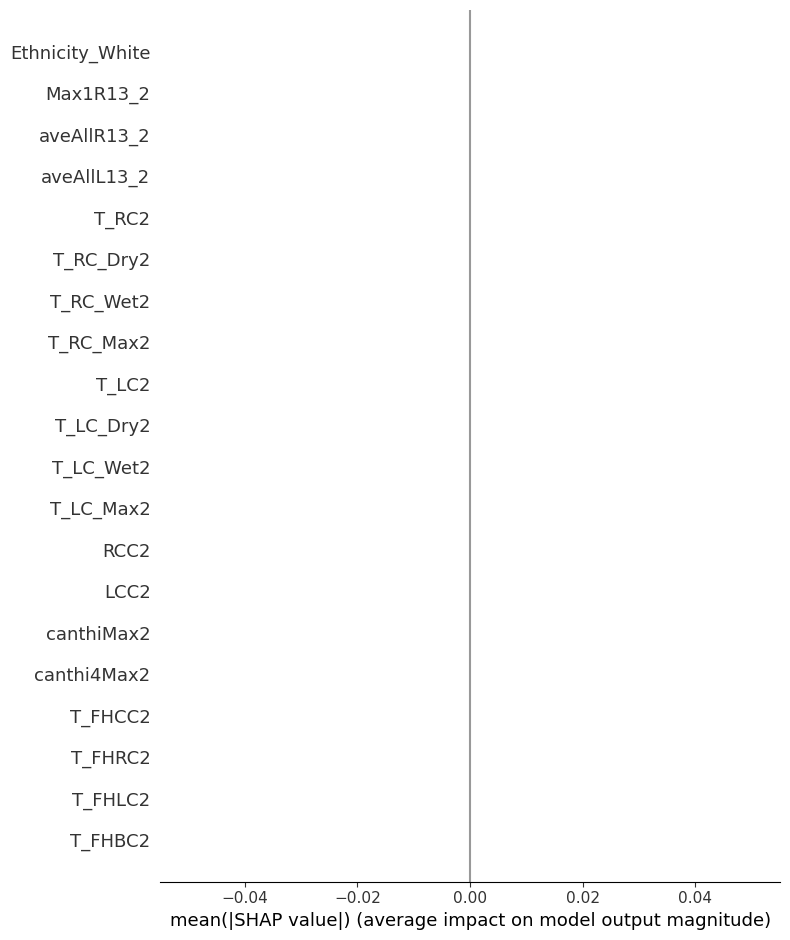

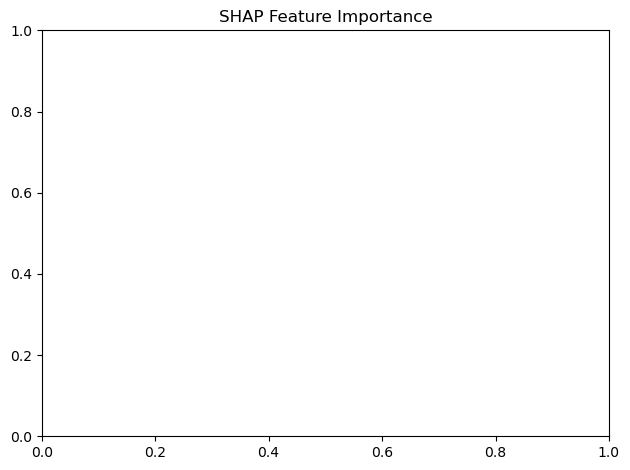

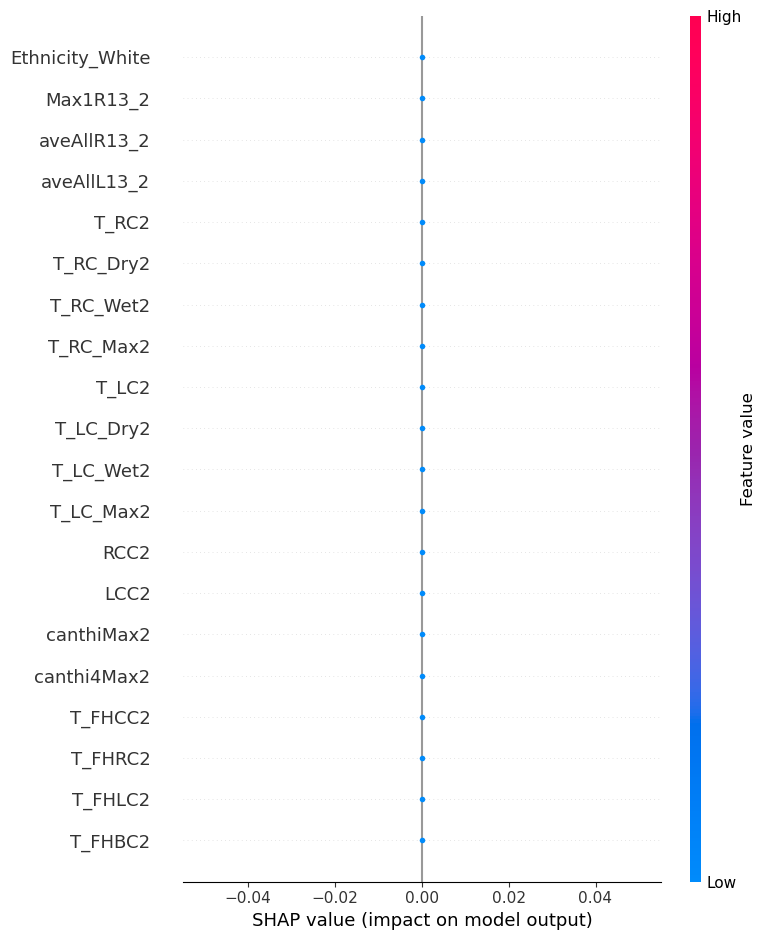

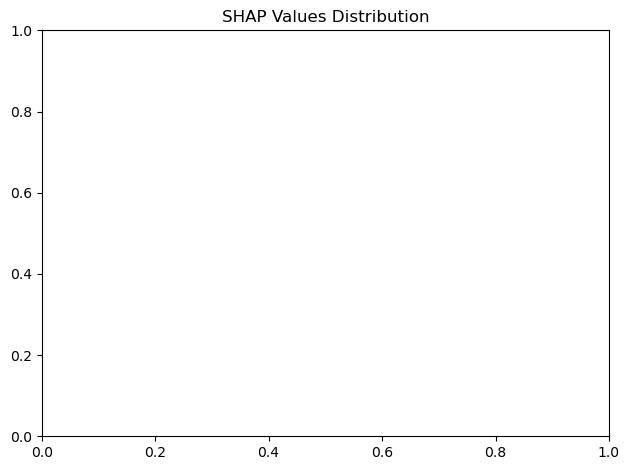

<Figure size 1000x600 with 0 Axes>

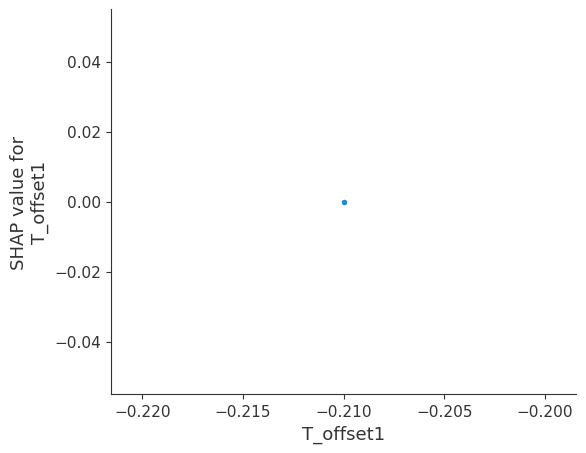

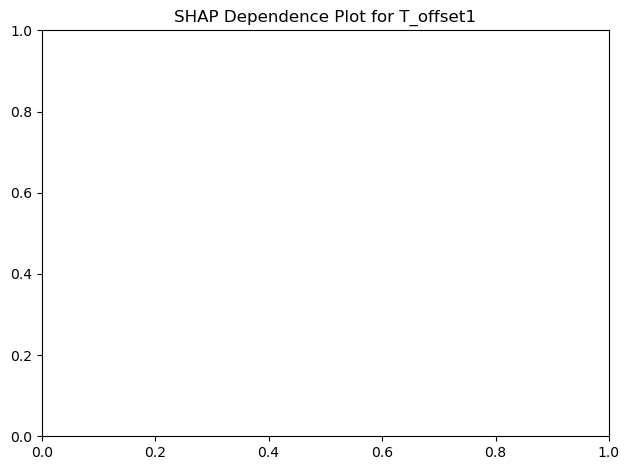

C:\Users\yashw\anaconda3\Lib\site-packages\shap\plots\_force_matplotlib.py:325: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(min_x, max_x)


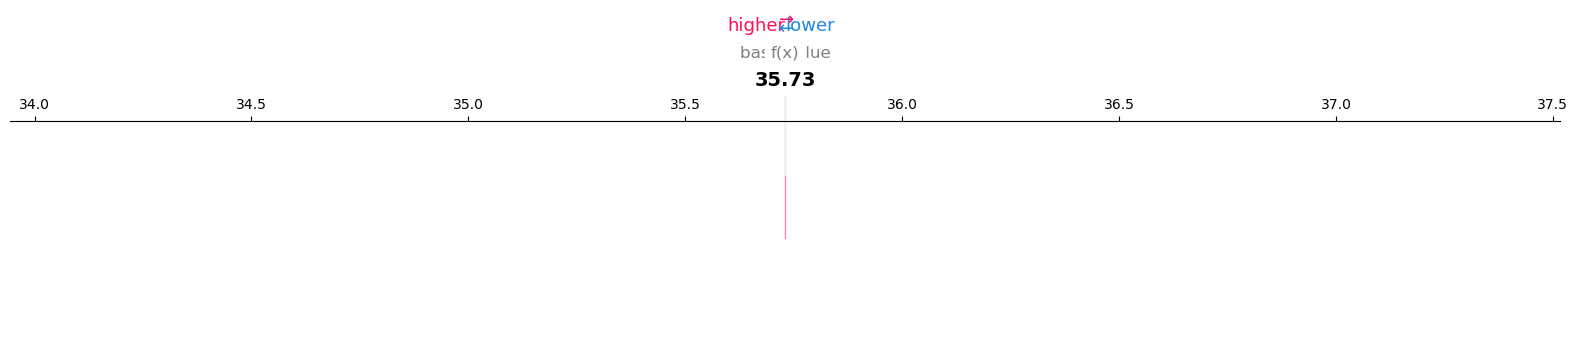

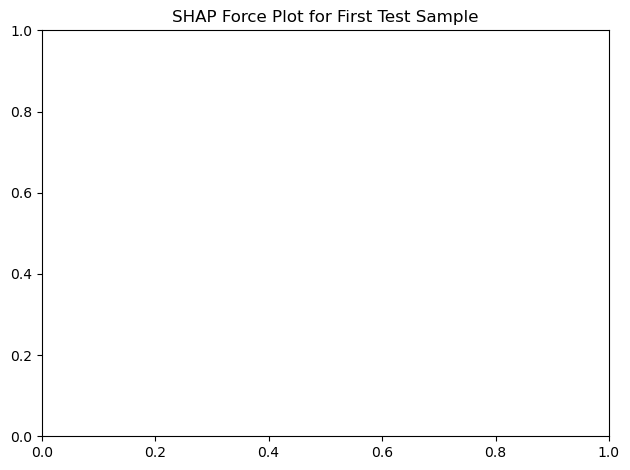

In [56]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import io

# Your dataset snippet (replace with full dataset)
dataset_text = """\
﻿,,Round 1:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 2:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 3:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Round 4:,,,,,,,,,,,,,,,,,,,,,,,,,,,,Other parameters: ,,,,,,,,,,
,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,T_CRmax,T_CLmax,T̅_CR,T̅_CL,,,,,,,,,,,T_CEmax,,T_FC,T_FR,T_FL,T_FB,T_FT,T_FEmax,T_FCmax,T_max,,T_Mmax,,,,,,,,,,,,
SubjectID,,T_offset1,Max1R13_1,Max1L13_1,aveAllR13_1,aveAllL13_1,T_RC1,T_RC_Dry1,T_RC_Wet1,T_RC_Max1,T_LC1,T_LC_Dry1,T_LC_Wet1,T_LC_Max1,RCC1,LCC1,canthiMax1,canthi4Max1,T_FHCC1,T_FHRC1,T_FHLC1,T_FHBC1,T_FHTC1,T_FH_Max1,T_FHC_Max1,T_Max1,T_OR1,T_OR_Max1,,T_offset2,Max1R13_2,Max1L13_2,aveAllR13_2,aveAllL13_2,T_RC2,T_RC_Dry2,T_RC_Wet2,T_RC_Max2,T_LC2,T_LC_Dry2,T_LC_Wet2,T_LC_Max2,RCC2,LCC2,canthiMax2,canthi4Max2,T_FHCC2,T_FHRC2,T_FHLC2,T_FHBC2,T_FHTC2,T_FH_Max2,T_FHC_Max2,T_Max2,T_OR2,T_OR_Max2,,T_offset3,Max1R13_3,Max1L13_3,aveAllR13_3,aveAllL13_3,T_RC3,T_RC_Dry3,T_RC_Wet3,T_RC_Max3,T_LC3,T_LC_Dry3,T_LC_Wet3,T_LC_Max3,RCC3,LCC3,canthiMax3,canthi4Max3,T_FHCC3,T_FHRC3,T_FHLC3,T_FHBC3,T_FHTC3,T_FH_Max3,T_FHC_Max3,T_Max3,T_OR3,T_OR_Max3,,T_offset4,Max1R13_4,Max1L13_4,aveAllR13_4,aveAllL13_4,T_RC4,T_RC_Dry4,T_RC_Wet4,T_RC_Max4,T_LC14,T_LC_Dry4,T_LC_Wet4,T_LC_Max4,RCC4,LCC4,canthiMax4,canthi4Max4,T_FHCC4,T_FHRC4,T_FHLC4,T_FHBC4,T_FHTC4,T_FH_Max4,T_FHC_Max4,T_Max4,T_OR4,T_OR_Max4,,aveOralF,aveOralM,Gender,Age,Ethnicity,T_atm,Humidity,Distance,Cosmetics,Time,Date
161117-1,,-0.27,34.94,35.48,34.05,34.74,34.92,34.92,34.71,34.94,35.45,35.45,34.17,35.49,34.75,33.90,35.48,35.45,33.06,32.86,32.81,32.97,32.23,34.42,33.53,35.49,35.39,35.42,,-0.49,34.91,35.34,34.10,34.79,34.90,34.90,34.65,34.91,35.33,35.33,34.22,35.34,34.77,34.17,35.34,35.33,33.17,32.98,32.88,33.16,32.44,34.30,33.59,35.74,35.73,35.74,,-0.41,35.05,35.42,34.50,34.79,35.03,35.03,34.35,35.05,35.40,35.40,34.24,35.42,34.34,34.11,35.42,35.40,33.29,33.17,32.96,33.13,32.53,34.46,33.63,35.84,35.73,35.84,,-0.58,34.96,35.51,34.16,34.60,34.94,34.94,34.80,34.96,35.41,35.41,34.04,35.51,34.85,33.74,35.51,35.41,33.31,33.18,32.97,33.22,32.65,34.10,33.73,36.39,36.38,36.39,,36.85,36.59,Male,41-50,White,24,28,0.8,,12:43:46,16-11-17
161117-2,,-0.21,33.56,34.93,33.23,34.14,34.80,33.97,34.80,34.89,34.88,34.88,33.86,34.93,33.16,33.62,34.96,34.94,33.52,33.01,32.85,33.56,33.34,34.38,33.90,34.96,34.81,34.89,,-0.56,33.79,34.57,32.73,33.95,34.54,34.09,34.54,34.56,34.54,34.54,33.72,34.57,33.45,33.31,34.57,34.57,33.95,33.61,33.30,33.99,33.75,34.60,34.26,35.45,35.19,35.24,,-0.49,33.39,33.91,33.03,33.12,34.26,34.20,34.26,34.30,34.48,34.48,34.03,34.53,32.75,32.84,34.98,34.86,33.71,33.43,33.60,33.95,33.52,34.63,34.25,35.32,35.21,35.22,,-0.39,34.31,34.32,33.03,33.92,34.73,34.43,34.73,34.79,34.46,34.33,34.46,34.54,34.15,34.12,34.79,34.73,33.65,33.86,33.44,33.67,33.52,34.36,34.17,36.30,36.28,36.30,,37.00,37.19,Female,31-40,Black or African-American,24,26,0.8,,15:22:48,16-11-17
"""

# Load the data with correct header
df = pd.read_csv(io.StringIO(dataset_text), header=2, encoding='utf-8')
df = df.dropna(axis=1, how='all')  # Drops columns like 'Cosmetics' if all NaN
df = df.reset_index(drop=True)

# Debug: Check columns and data
print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())
print("First few rows:\n", df.head())

# Define target
target = "T_OR3"
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in dataset! Available 'T_OR' columns: {[col for col in df.columns if 'T_OR' in col]}")

# Select features, only dropping columns that exist
exclude_cols = [target, 'SubjectID', 'Gender', 'Age', 'Ethnicity', 'Date', 'Time', 'Cosmetics']
existing_cols = [col for col in exclude_cols if col in df.columns]  # Filter to existing columns
X = df.drop(columns=existing_cols)
y = pd.to_numeric(df[target], errors='coerce')

# Convert features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle categorical variables
categorical_cols = ['Gender', 'Age', 'Ethnicity']
available_cat_cols = [col for col in categorical_cols if col in df.columns]  # Check available categorical columns
X_cat = pd.get_dummies(df[available_cat_cols], drop_first=True)
X = pd.concat([X, X_cat], axis=1)

# Handle missing values
X = X.fillna(X.mean())
y = y.dropna()
X = X.loc[y.index]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
print("\nModel Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# SHAP Plots
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.title("SHAP Values Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("T_offset1", shap_values, X_test, interaction_index=None)
plt.title("SHAP Dependence Plot for T_offset1")
plt.tight_layout()
plt.show()

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
plt.title("SHAP Force Plot for First Test Sample")
plt.tight_layout()
plt.show()

In [66]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import io

# Replace with your FULL dataset (50+ rows)
dataset_text = """ICI_groups1and2.csv"""

# Load the data with correct header
df = pd.read_csv(io.StringIO(dataset_text), header=2, encoding='utf-8')
df = df.dropna(axis=1, how='all')  # Drops columns like 'Cosmetics' if all NaN
df = df.reset_index(drop=True)

# Debug: Check columns and data
print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())
print("First few rows:\n", df.head())

# Define target
target = "T_OR3"
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in dataset! Available 'T_OR' columns: {[col for col in df.columns if 'T_OR' in col]}")

# Select features, only dropping columns that exist
exclude_cols = [target, 'SubjectID', 'Gender', 'Age', 'Ethnicity', 'Date', 'Time', 'Cosmetics']
existing_cols = [col for col in exclude_cols if col in df.columns]
X = df.drop(columns=existing_cols)
y = pd.to_numeric(df[target], errors='coerce')

# Convert features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle categorical variables
categorical_cols = ['Gender', 'Age', 'Ethnicity']
available_cat_cols = [col for col in categorical_cols if col in df.columns]
X_cat = pd.get_dummies(df[available_cat_cols], drop_first=True)
X = pd.concat([X, X_cat], axis=1)

# Handle missing values
X = X.fillna(X.mean())
y = y.dropna()
X = X.loc[y.index]

# Check if enough samples for split
if len(X) < 5:  # Arbitrary threshold to ensure meaningful split
    raise ValueError(f"Dataset too small ({len(X)} rows) for train-test split. Need at least 5 rows.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Validate split
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
if len(y_test) < 2:
    raise ValueError("Test set has fewer than 2 samples, R² score will be undefined.")

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
print("\nModel Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# SHAP Plots
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.title("SHAP Values Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("T_offset1", shap_values, X_test, interaction_index=None)
plt.title("SHAP Dependence Plot for T_offset1")
plt.tight_layout()
plt.show()

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
plt.title("SHAP Force Plot for First Test Sample")
plt.tight_layout()
plt.show()

Shape of df: (2, 119)
Columns: ['SubjectID', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'T_offset2', 'Max1R13_2', 'Max1L13_2', 'aveAllR13_2', 'aveAllL13_2', 'T_RC2', 'T_RC_Dry2', 'T_RC_Wet2', 'T_RC_Max2', 'T_LC2', 'T_LC_Dry2', 'T_LC_Wet2', 'T_LC_Max2', 'RCC2', 'LCC2', 'canthiMax2', 'canthi4Max2', 'T_FHCC2', 'T_FHRC2', 'T_FHLC2', 'T_FHBC2', 'T_FHTC2', 'T_FH_Max2', 'T_FHC_Max2', 'T_Max2', 'T_OR2', 'T_OR_Max2', 'T_offset3', 'Max1R13_3', 'Max1L13_3', 'aveAllR13_3', 'aveAllL13_3', 'T_RC3', 'T_RC_Dry3', 'T_RC_Wet3', 'T_RC_Max3', 'T_LC3', 'T_LC_Dry3', 'T_LC_Wet3', 'T_LC_Max3', 'RCC3', 'LCC3', 'canthiMax3', 'canthi4Max3', 'T_FHCC3', 'T_FHRC3', 'T_FHLC3', 'T_FHBC3', 'T_FHTC3', 'T_FH_Max3', 'T_FHC_Max3', 'T_Max3', 'T_OR

ValueError: Dataset too small (2 rows) for train-test split. Need at least 5 rows.

Shape of df: (1009, 120)
Columns: ['SubjectID', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'T_offset2', 'Max1R13_2', 'Max1L13_2', 'aveAllR13_2', 'aveAllL13_2', 'T_RC2', 'T_RC_Dry2', 'T_RC_Wet2', 'T_RC_Max2', 'T_LC2', 'T_LC_Dry2', 'T_LC_Wet2', 'T_LC_Max2', 'RCC2', 'LCC2', 'canthiMax2', 'canthi4Max2', 'T_FHCC2', 'T_FHRC2', 'T_FHLC2', 'T_FHBC2', 'T_FHTC2', 'T_FH_Max2', 'T_FHC_Max2', 'T_Max2', 'T_OR2', 'T_OR_Max2', 'T_offset3', 'Max1R13_3', 'Max1L13_3', 'aveAllR13_3', 'aveAllL13_3', 'T_RC3', 'T_RC_Dry3', 'T_RC_Wet3', 'T_RC_Max3', 'T_LC3', 'T_LC_Dry3', 'T_LC_Wet3', 'T_LC_Max3', 'RCC3', 'LCC3', 'canthiMax3', 'canthi4Max3', 'T_FHCC3', 'T_FHRC3', 'T_FHLC3', 'T_FHBC3', 'T_FHTC3', 'T_FH_Max3', 'T_FHC_Max3', 'T_Max3', 'T

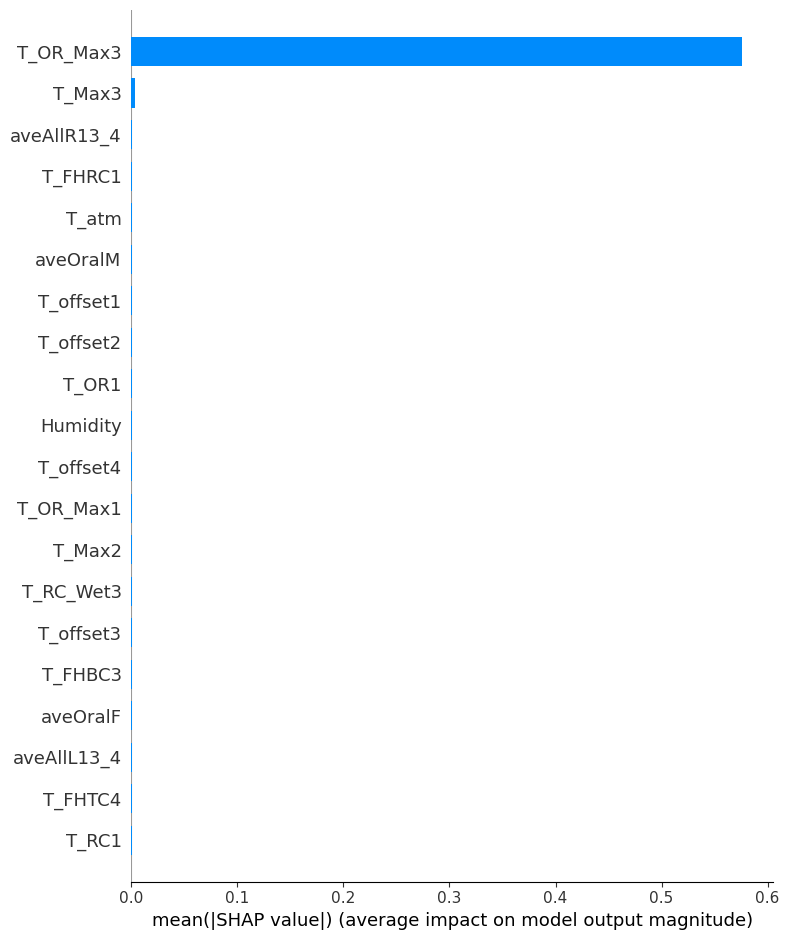

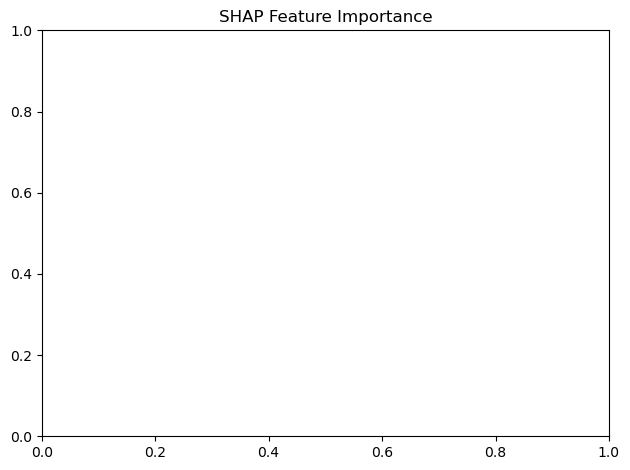

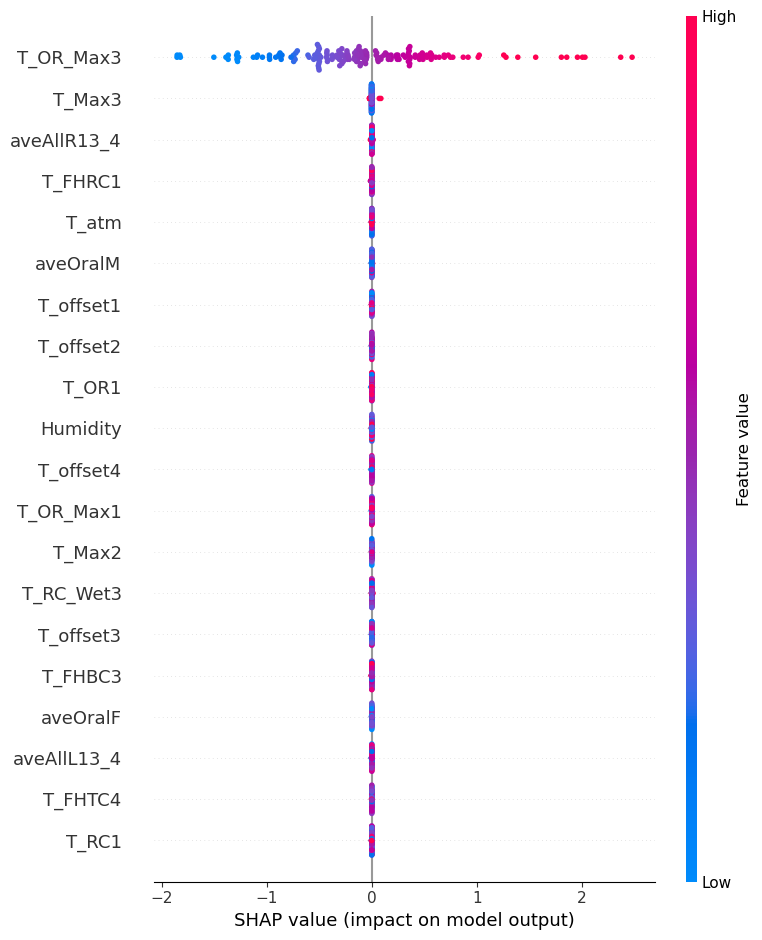

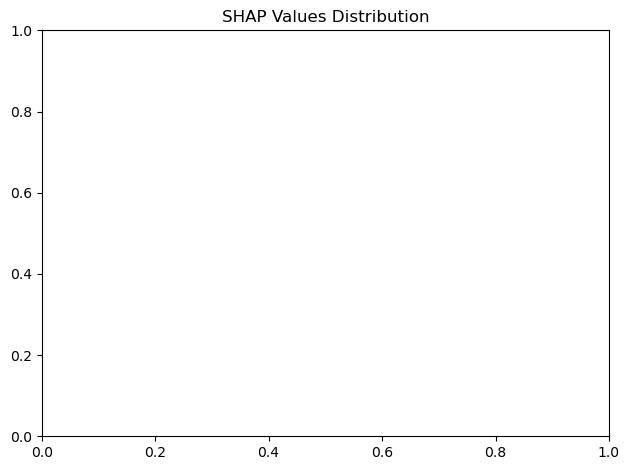

<Figure size 1000x600 with 0 Axes>

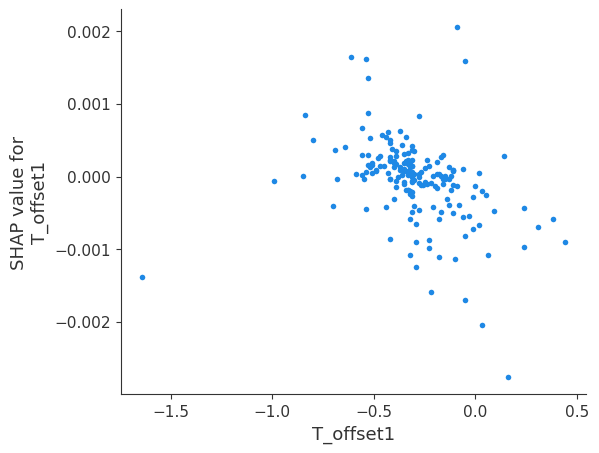

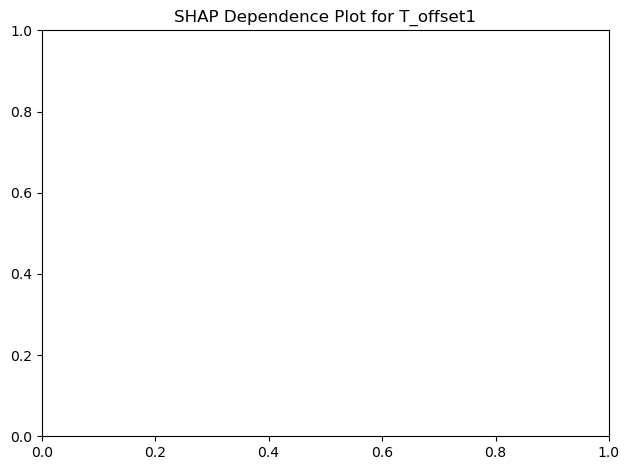

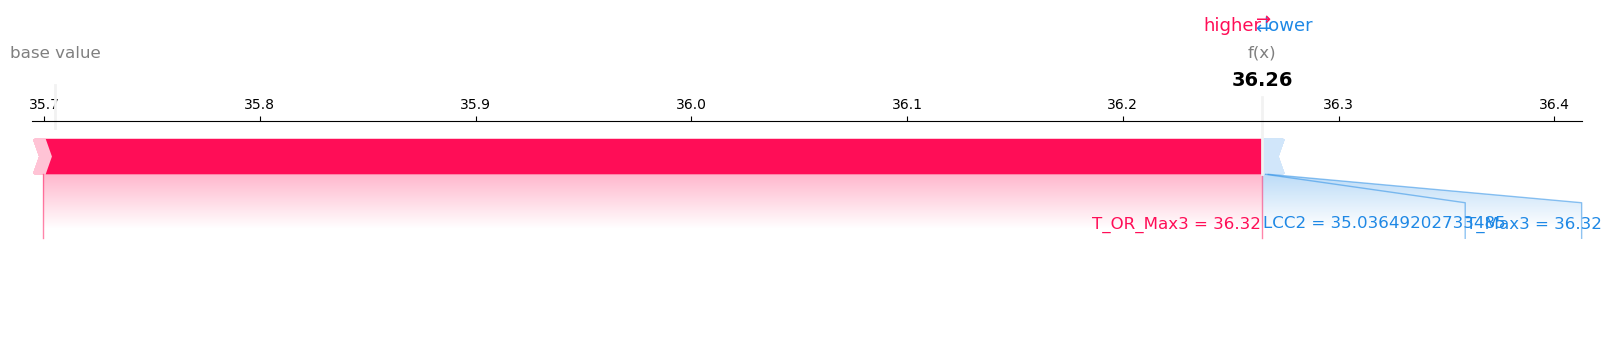

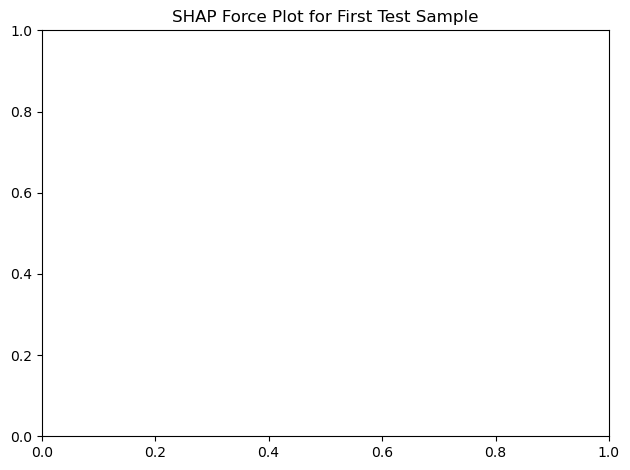

In [68]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the data from file
df = pd.read_csv("ICI_groups1and2.csv", header=2, encoding='utf-8')
df = df.dropna(axis=1, how='all')  # Drops columns like 'Cosmetics' if all NaN
df = df.reset_index(drop=True)

# Debug: Check columns and data
print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())
print("First few rows:\n", df.head())

# Define target
target = "T_OR3"
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in dataset! Available 'T_OR' columns: {[col for col in df.columns if 'T_OR' in col]}")

# Select features, only dropping columns that exist
exclude_cols = [target, 'SubjectID', 'Gender', 'Age', 'Ethnicity', 'Date', 'Time', 'Cosmetics']
existing_cols = [col for col in exclude_cols if col in df.columns]
X = df.drop(columns=existing_cols)
y = pd.to_numeric(df[target], errors='coerce')

# Convert features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle categorical variables
categorical_cols = ['Gender', 'Age', 'Ethnicity']
available_cat_cols = [col for col in categorical_cols if col in df.columns]
X_cat = pd.get_dummies(df[available_cat_cols], drop_first=True)
X = pd.concat([X, X_cat], axis=1)

# Handle missing values
X = X.fillna(X.mean())
y = y.dropna()
X = X.loc[y.index]

# Check if enough samples for split
if len(X) < 5:  # Arbitrary threshold to ensure meaningful split
    raise ValueError(f"Dataset too small ({len(X)} rows) for train-test split. Need at least 5 rows.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Validate split
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
if len(y_test) < 2:
    raise ValueError("Test set has fewer than 2 samples, R² score will be undefined.")

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
print("\nModel Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# SHAP analysis
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# SHAP Plots
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test)
plt.title("SHAP Values Distribution")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
shap.dependence_plot("T_offset1", shap_values, X_test, interaction_index=None)
plt.title("SHAP Dependence Plot for T_offset1")
plt.tight_layout()
plt.show()

shap.force_plot(explainer.expected_value, shap_values[0,:], X_test.iloc[0,:], matplotlib=True)
plt.title("SHAP Force Plot for First Test Sample")
plt.tight_layout()
plt.show()

Shape of df: (1009, 120)
Columns: ['SubjectID', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'T_offset2', 'Max1R13_2', 'Max1L13_2', 'aveAllR13_2', 'aveAllL13_2', 'T_RC2', 'T_RC_Dry2', 'T_RC_Wet2', 'T_RC_Max2', 'T_LC2', 'T_LC_Dry2', 'T_LC_Wet2', 'T_LC_Max2', 'RCC2', 'LCC2', 'canthiMax2', 'canthi4Max2', 'T_FHCC2', 'T_FHRC2', 'T_FHLC2', 'T_FHBC2', 'T_FHTC2', 'T_FH_Max2', 'T_FHC_Max2', 'T_Max2', 'T_OR2', 'T_OR_Max2', 'T_offset3', 'Max1R13_3', 'Max1L13_3', 'aveAllR13_3', 'aveAllL13_3', 'T_RC3', 'T_RC_Dry3', 'T_RC_Wet3', 'T_RC_Max3', 'T_LC3', 'T_LC_Dry3', 'T_LC_Wet3', 'T_LC_Max3', 'RCC3', 'LCC3', 'canthiMax3', 'canthi4Max3', 'T_FHCC3', 'T_FHRC3', 'T_FHLC3', 'T_FHBC3', 'T_FHTC3', 'T_FH_Max3', 'T_FHC_Max3', 'T_Max3', 'T

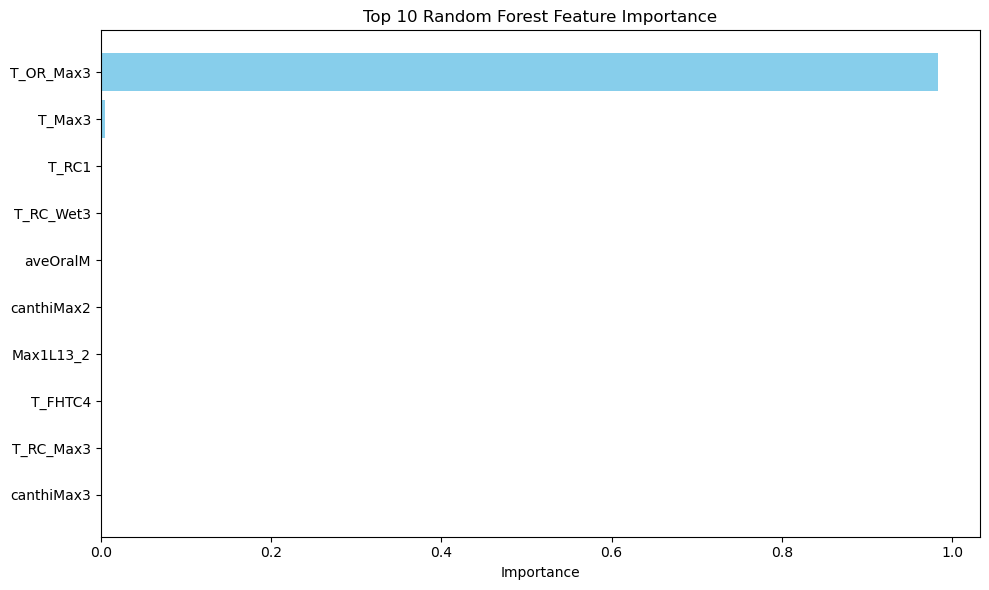


SHAP Feature Importance (Top 10):
         Feature  Importance
79     T_OR_Max3    0.576278
78        T_Max3    0.003600
83   aveAllR13_4    0.000601
18       T_FHRC1    0.000484
109        T_atm    0.000467
108     aveOralM    0.000412
0      T_offset1    0.000374
27     T_offset2    0.000369
25         T_OR1    0.000356
110     Humidity    0.000355


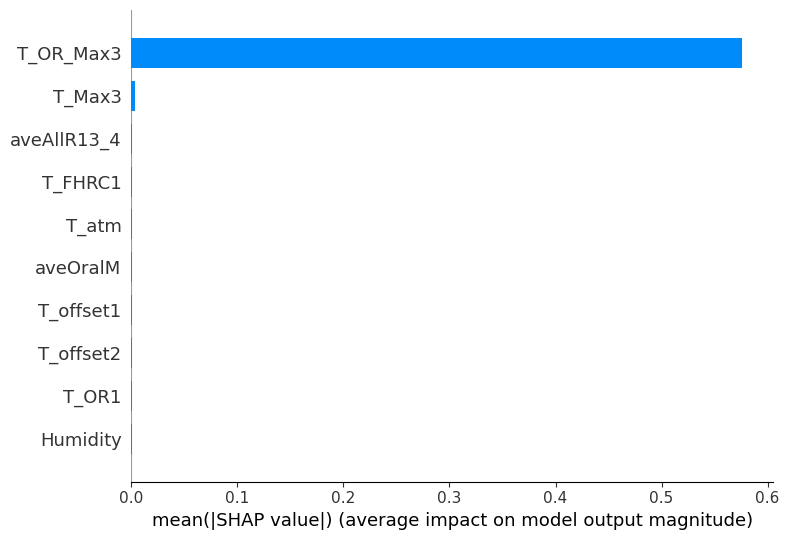

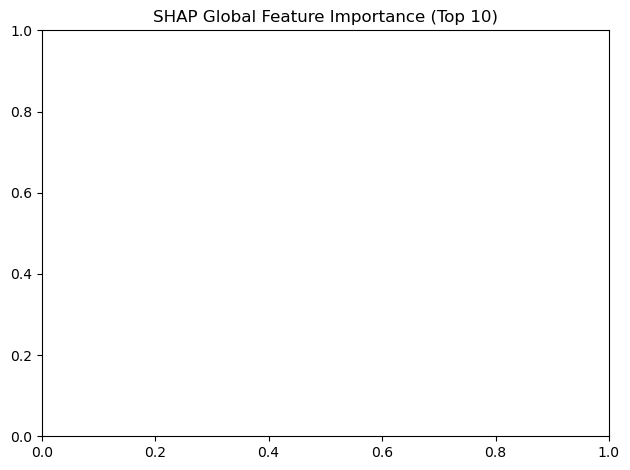

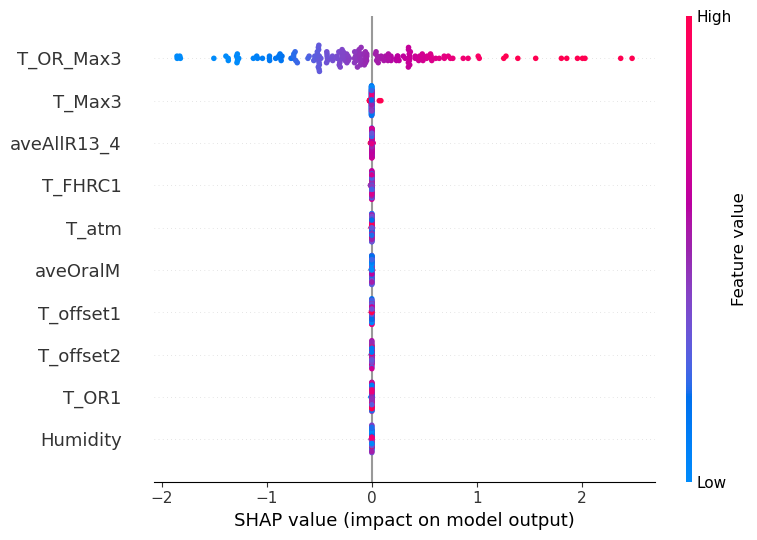

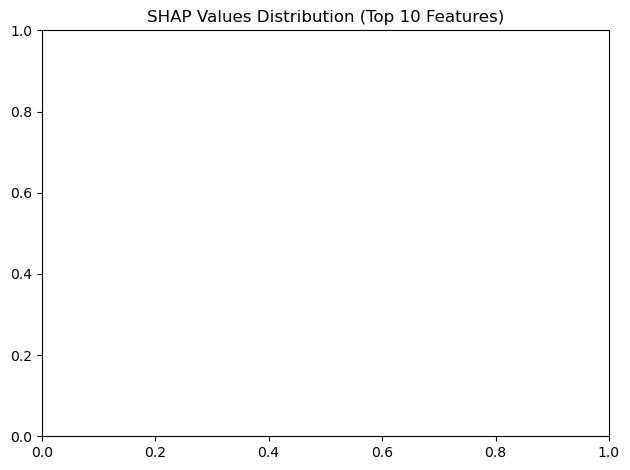

In [70]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the data from file (adjust path as needed)
df = pd.read_csv("ICI_groups1and2.csv", header=2, encoding='utf-8')
df = df.dropna(axis=1, how='all')  # Drops columns like 'Cosmetics' if all NaN
df = df.reset_index(drop=True)

# Debug: Check columns and data
print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())
print("First few rows:\n", df.head())

# Define target
target = "T_OR3"
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in dataset! Available 'T_OR' columns: {[col for col in df.columns if 'T_OR' in col]}")

# Select features, only dropping columns that exist
exclude_cols = [target, 'SubjectID', 'Gender', 'Age', 'Ethnicity', 'Date', 'Time', 'Cosmetics']
existing_cols = [col for col in exclude_cols if col in df.columns]
X = df.drop(columns=existing_cols)
y = pd.to_numeric(df[target], errors='coerce')

# Convert features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle categorical variables
categorical_cols = ['Gender', 'Age', 'Ethnicity']
available_cat_cols = [col for col in categorical_cols if col in df.columns]
X_cat = pd.get_dummies(df[available_cat_cols], drop_first=True)
X = pd.concat([X, X_cat], axis=1)

# Handle missing values
X = X.fillna(X.mean())
y = y.dropna()
X = X.loc[y.index]

# Check if enough samples for split
if len(X) < 5:
    raise ValueError(f"Dataset too small ({len(X)} rows) for train-test split. Need at least 5 rows.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Validate split
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
if len(y_test) < 2:
    raise ValueError("Test set has fewer than 2 samples, R² score will be undefined.")

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
print("\nModel Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# 1. Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance (Top 10):")
print(rf_importance.head(10))

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(rf_importance['Feature'][:10], rf_importance['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. SHAP Feature Importance
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for global importance
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)

print("\nSHAP Feature Importance (Top 10):")
print(shap_importance.head(10))

# SHAP Summary Plot (Bar) for Global Importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)
plt.title("SHAP Global Feature Importance (Top 10)")
plt.tight_layout()
plt.show()

# Optional: Detailed SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, max_display=10)
plt.title("SHAP Values Distribution (Top 10 Features)")
plt.tight_layout()
plt.show()

In [72]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

Shape of df: (1009, 120)
Columns: ['SubjectID', 'T_offset1', 'Max1R13_1', 'Max1L13_1', 'aveAllR13_1', 'aveAllL13_1', 'T_RC1', 'T_RC_Dry1', 'T_RC_Wet1', 'T_RC_Max1', 'T_LC1', 'T_LC_Dry1', 'T_LC_Wet1', 'T_LC_Max1', 'RCC1', 'LCC1', 'canthiMax1', 'canthi4Max1', 'T_FHCC1', 'T_FHRC1', 'T_FHLC1', 'T_FHBC1', 'T_FHTC1', 'T_FH_Max1', 'T_FHC_Max1', 'T_Max1', 'T_OR1', 'T_OR_Max1', 'T_offset2', 'Max1R13_2', 'Max1L13_2', 'aveAllR13_2', 'aveAllL13_2', 'T_RC2', 'T_RC_Dry2', 'T_RC_Wet2', 'T_RC_Max2', 'T_LC2', 'T_LC_Dry2', 'T_LC_Wet2', 'T_LC_Max2', 'RCC2', 'LCC2', 'canthiMax2', 'canthi4Max2', 'T_FHCC2', 'T_FHRC2', 'T_FHLC2', 'T_FHBC2', 'T_FHTC2', 'T_FH_Max2', 'T_FHC_Max2', 'T_Max2', 'T_OR2', 'T_OR_Max2', 'T_offset3', 'Max1R13_3', 'Max1L13_3', 'aveAllR13_3', 'aveAllL13_3', 'T_RC3', 'T_RC_Dry3', 'T_RC_Wet3', 'T_RC_Max3', 'T_LC3', 'T_LC_Dry3', 'T_LC_Wet3', 'T_LC_Max3', 'RCC3', 'LCC3', 'canthiMax3', 'canthi4Max3', 'T_FHCC3', 'T_FHRC3', 'T_FHLC3', 'T_FHBC3', 'T_FHTC3', 'T_FH_Max3', 'T_FHC_Max3', 'T_Max3', 'T

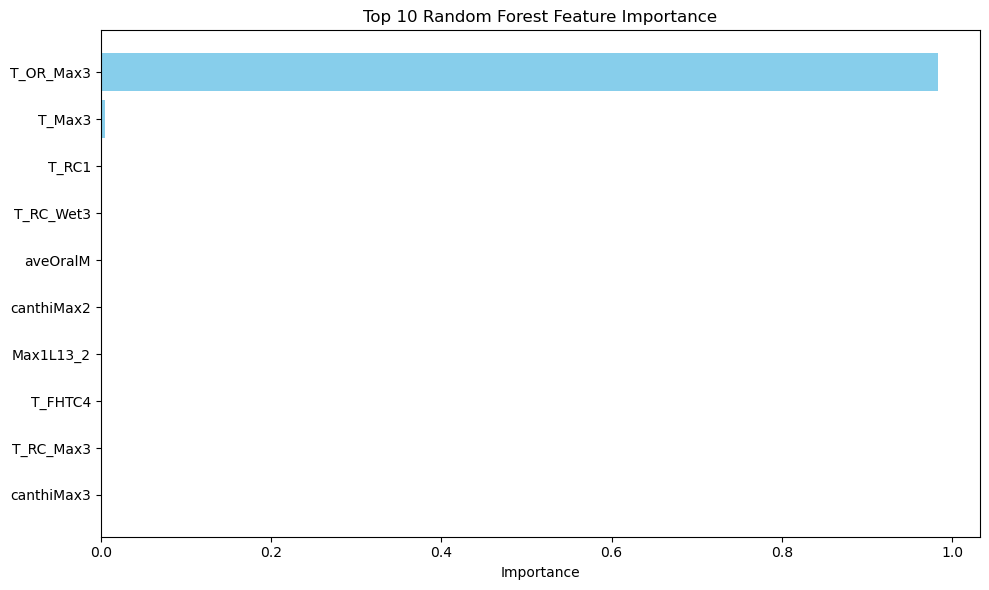


SHAP Feature Importance (Top 10):
         Feature  Importance
79     T_OR_Max3    0.576278
78        T_Max3    0.003600
83   aveAllR13_4    0.000601
18       T_FHRC1    0.000484
109        T_atm    0.000467
108     aveOralM    0.000412
0      T_offset1    0.000374
27     T_offset2    0.000369
25         T_OR1    0.000356
110     Humidity    0.000355


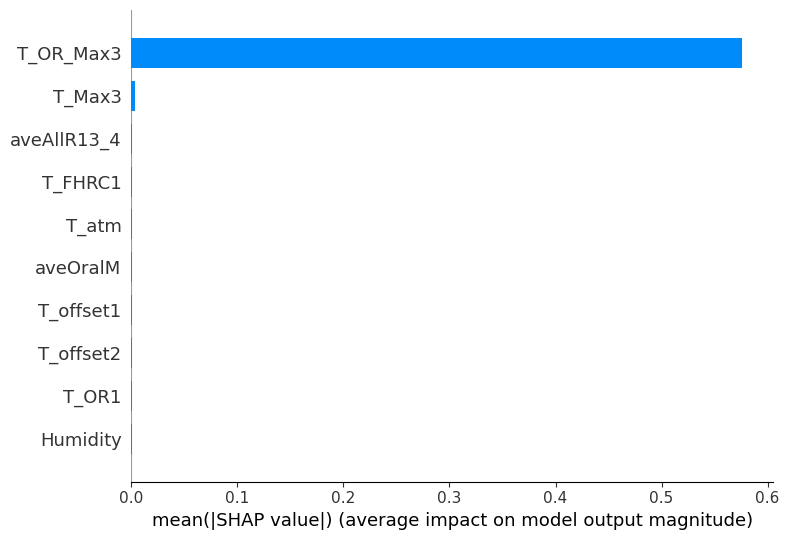

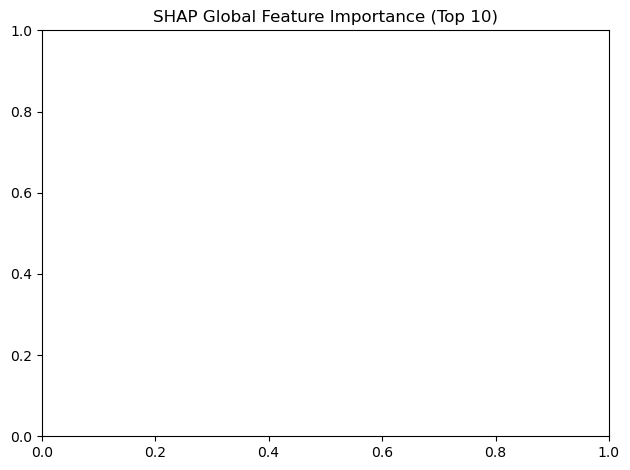

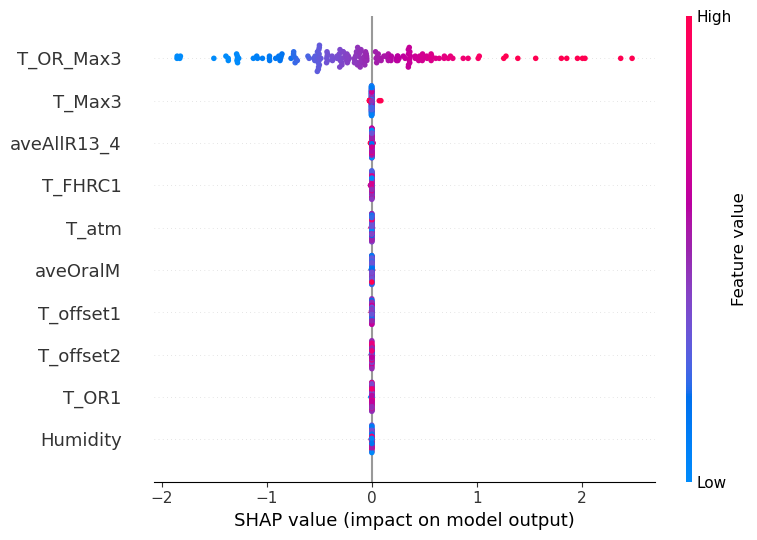

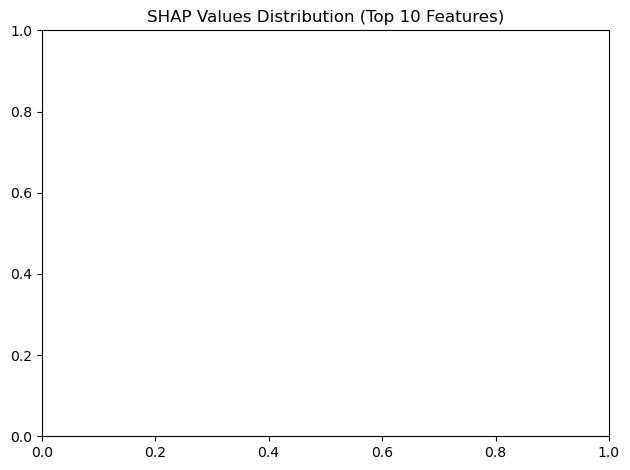

In [74]:
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Load the data from file (adjust path as needed)
df = pd.read_csv("ICI_groups1and2.csv", header=2, encoding='utf-8')
df = df.dropna(axis=1, how='all')  # Drops columns like 'Cosmetics' if all NaN
df = df.reset_index(drop=True)

# Debug: Check columns and data
print("Shape of df:", df.shape)
print("Columns:", df.columns.tolist())
print("First few rows:\n", df.head())

# Define target
target = "T_OR3"
if target not in df.columns:
    raise KeyError(f"Target column '{target}' not found in dataset! Available 'T_OR' columns: {[col for col in df.columns if 'T_OR' in col]}")

# Select features, only dropping columns that exist
exclude_cols = [target, 'SubjectID', 'Gender', 'Age', 'Ethnicity', 'Date', 'Time', 'Cosmetics']
existing_cols = [col for col in exclude_cols if col in df.columns]
X = df.drop(columns=existing_cols)
y = pd.to_numeric(df[target], errors='coerce')

# Convert features to numeric
X = X.apply(pd.to_numeric, errors='coerce')

# Handle categorical variables
categorical_cols = ['Gender', 'Age', 'Ethnicity']
available_cat_cols = [col for col in categorical_cols if col in df.columns]
X_cat = pd.get_dummies(df[available_cat_cols], drop_first=True)
X = pd.concat([X, X_cat], axis=1)

# Handle missing values
X = X.fillna(X.mean())
y = y.dropna()
X = X.loc[y.index]

# Check if enough samples for split
if len(X) < 5:
    raise ValueError(f"Dataset too small ({len(X)} rows) for train-test split. Need at least 5 rows.")

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Validate split
print(f"Train set size: {len(X_train)}, Test set size: {len(X_test)}")
if len(y_test) < 2:
    raise ValueError("Test set has fewer than 2 samples, R² score will be undefined.")

# Train Random Forest Regressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model evaluation
y_pred = rf_model.predict(X_test)
print("\nModel Performance:")
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

# 1. Random Forest Feature Importance
rf_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nRandom Forest Feature Importance (Top 10):")
print(rf_importance.head(10))

# Plot Random Forest Feature Importance
plt.figure(figsize=(10, 6))
plt.barh(rf_importance['Feature'][:10], rf_importance['Importance'][:10], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Random Forest Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 2. SHAP Feature Importance
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test)

# Calculate mean absolute SHAP values for global importance
shap_importance = pd.DataFrame({
    'Feature': X_test.columns,
    'Importance': np.abs(shap_values).mean(axis=0)
}).sort_values(by='Importance', ascending=False)

print("\nSHAP Feature Importance (Top 10):")
print(shap_importance.head(10))

# SHAP Summary Plot (Bar) for Global Importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, plot_type="bar", max_display=10)
plt.title("SHAP Global Feature Importance (Top 10)")
plt.tight_layout()
plt.show()

# Optional: Detailed SHAP Summary Plot
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values, X_test, max_display=10)
plt.title("SHAP Values Distribution (Top 10 Features)")
plt.tight_layout()
plt.show()